# Reproducing Figure 4

In [23]:
###################
# Import packages #
###################

import numpy as np
from scipy.special import gammainc
from scipy import interpolate
import arviz as az
import sys
import csv

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Rate definition

In [3]:
rateData_MD = np.load('../data/delayedRateDataMD.npy', allow_pickle=True)[()]
formationRates_MD = rateData_MD['formationRates']
tdelays_MD = rateData_MD['tds']
zformation_MD = rateData_MD['zs']

In [4]:
dz = 0.01
zs = np.arange(0.,10.0,dz) # NOTE: should be same array as what was used to make the delayedRateDataMD.npy file

def R_norm_MD(zs, metMin_td, lambda_td, tdmin):
    fs = gammainc(0.84,(metMin_td**2.)*np.power(10.,0.3*zformation_MD))[...,None]
    weightedFormationRates_MD = formationRates_MD*fs

    dpdt = np.power(tdelays_MD,lambda_td)
    dpdt[tdelays_MD<tdmin] = 0.
    dpdt[tdelays_MD>13.5] = 0.
    mergerRate_MD = weightedFormationRates_MD.dot(dpdt)

    R = mergerRate_MD
    f = interpolate.interp1d(zs, R)
    norm = f(0.2)
    return R, norm

## Loading data

In [5]:
data_CBC_GWB_MD_O3 = az.from_netcdf("../data/O3_CBC_GWB_MD.cdf")

In [6]:
stacked_samples_CBC_GWB_MD_O3 = data_CBC_GWB_MD_O3.posterior.stack(draws=("chain", "draw"))

In [7]:
sys.path.append("../code/")

In [8]:
from gwBackground import *

In [9]:
all_zs = np.linspace(0,10,200)
omg = OmegaGW_BBH(2.1,100.,all_zs)

In [10]:
freqs = np.arange(10,1000,1)

In [11]:
grid=zs

nTraces = 1500

random_indices = np.random.choice(np.arange(stacked_samples_CBC_GWB_MD_O3.logR20.size),size=nTraces,replace=False)

omega_array_CBC_GWB = np.zeros(nTraces, dtype=np.ndarray)
for ii,ind in enumerate(random_indices):
    if ii%100==0:
        print(ii)
    lambda_td = stacked_samples_CBC_GWB_MD_O3.lambda_td.values[ii]
    metMin_td = stacked_samples_CBC_GWB_MD_O3.metMin_td.values[ii]
    logR20 = stacked_samples_CBC_GWB_MD_O3.logR20.values[ii]
    td_min = stacked_samples_CBC_GWB_MD_O3.td_min.values[ii]
    merger_rate_tmp, rate_02_tmp = R_norm_MD(grid, metMin_td, lambda_td, td_min)
    rate_tmp = jnp.interp(all_zs, zs, merger_rate_tmp)
    omg.setProbs_plPeak(stacked_samples_CBC_GWB_MD_O3.mMin[ii].data.flatten()[0],stacked_samples_CBC_GWB_MD_O3.mMax[ii].data.flatten()[0],stacked_samples_CBC_GWB_MD_O3.alpha[ii].data.flatten()[0],stacked_samples_CBC_GWB_MD_O3.mu_m1[ii].data.flatten()[0],stacked_samples_CBC_GWB_MD_O3.sig_m1[ii].data.flatten()[0],10.**stacked_samples_CBC_GWB_MD_O3.log_f_peak[ii].data.flatten()[0],stacked_samples_CBC_GWB_MD_O3.bq[ii].data.flatten()[0], stacked_samples_CBC_GWB_MD_O3.R20[ii].data.flatten()[0], 10.**stacked_samples_CBC_GWB_MD_O3.log_dmMax[ii].data.flatten()[0],10.**stacked_samples_CBC_GWB_MD_O3.log_dmMin[ii].data.flatten()[0])
    Omega_f = omg.eval(rate_tmp, rate_02_tmp, freqs)
    omega_array_CBC_GWB[ii] = Omega_f

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [12]:
p_omega_array_CBC_GWB = np.zeros((nTraces,freqs.shape[0]))
for ii in range(nTraces):
    p_omega_array_CBC_GWB[ii,:] = omega_array_CBC_GWB[ii]

In [24]:
freqs_PI_O3 = np.array([])
omega_PI_O3 = np.array([])

with open('../data/O3_PI_curve.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=' ')
    line_count = 0
    for row in csv_reader:
        freqs_PI_O3 = np.append(freqs_PI_O3,float(row[0]))
        omega_PI_O3 = np.append(omega_PI_O3,float(row[1]))
        line_count += 1

## Plotting

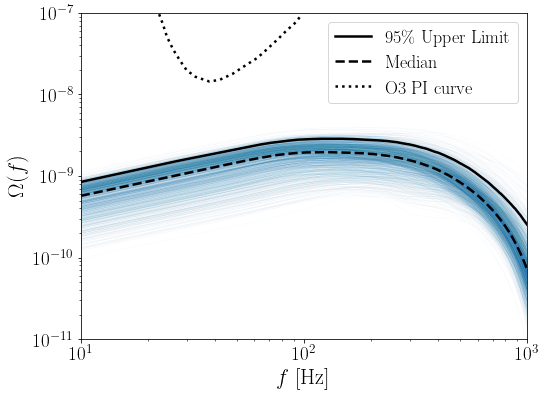

In [30]:
for ii in range(nTraces):
    plt.loglog(freqs, omega_array_CBC_GWB[ii],color=my_palette[0],lw=0.15,alpha=0.1)
plt.loglog(freqs,np.quantile(p_omega_array_CBC_GWB,0.95,axis=0),lw=2.5,alpha=1,c='k', label="95$\%$ Upper Limit")
plt.loglog(freqs,np.median(p_omega_array_CBC_GWB,axis=0),lw=2.5, alpha=1,c='k', ls="dashed", label="Median")
plt.loglog(freqs_PI_O3, omega_PI_O3, ls='dotted', c='k', label="O3 PI curve", lw=2.5)
plt.xlabel("$f$ [Hz]", fontsize=22)
plt.ylim(1e-11,1e-7)
plt.xlim(10,1000)
plt.ylabel("$\Omega(f)$", fontsize=22)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=19)